In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import note_seq
import tensorflow as tf
import librosa as lr
import aubio
import matplotlib.pyplot as plt
import glob

from tqdm import tqdm
from pathlib import PurePath
import magenta as mg

from magenta.models.drums_rnn import drums_rnn_model

import vxs
import vxs.utils as vxsu

In [2]:
GROOVE_DIR = PurePath('../data/groove-midi/groove')
groove_info = pd.read_csv(GROOVE_DIR / 'info.csv')

In [3]:
groove_info

,drummer,session,id,style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308,test
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,102,beat,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,37.691158,test
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,105,beat,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218,test
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,86,beat,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,44.716543,test
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,80,beat,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,47.987500,test
...,...,...,...,...,...,...,...,...,...,...,...
1145,drummer2,drummer2/session2,drummer2/session2/11,rock,130,beat,4-4,drummer2/session2/11_rock_130_beat_4-4.mid,NaN,1.909613,train
1146,drummer2,drummer2/session2,drummer2/session2/12,rock,130,beat,4-4,drummer2/session2/12_rock_130_beat_4-4.mid,NaN,1.808652,train
1147,drummer2,drummer2/session2,drummer2/session2/13,rock,130,beat,4-4,drummer2/session2/13_rock_130_beat_4-4.mid,NaN,1.864421,train
1148,drummer2,drummer2/session2,drummer2/session2/14,rock,130,beat,4-4,drummer2/session2/14_rock_130_beat_4-4.mid,NaN,1.875960,train


In [7]:
bbs1_samples = vxs.SimpleSampleSet(glob.glob('../data_temp/beatboxset1/DR/*/*.wav'))


In [8]:
cl_counts = {}
for cl in ['kd', 'sd', 'hhc', 'hho']:
    cl_counts[cl] = (bbs1_samples.classes == cl).sum()
    
cl_counts

{'kd': 627, 'sd': 703, 'hhc': 882, 'hho': 105}

In [9]:
len(bbs1_samples)

2317

In [9]:
probas = {k: v / sum(cl_counts.values()) for k, v in cl_counts.items()}

In [10]:
probas

{'kd': 0.27060854553301683,
 'sd': 0.3034095813552007,
 'hhc': 0.3806646525679758,
 'hho': 0.045317220543806644}

In [5]:
encoder = note_seq.MultiDrumOneHotEncoding(drums_rnn_model.REDUCED_DRUM_TYPE_PITCHES)

In [24]:
def count_drums(encoder, counters, event):
    drum_type_indices = set()
    for pitch in event:
        if pitch in encoder._inverse_drum_map:
            idx = encoder._inverse_drum_map[pitch]
            try:
                counters[idx] += 1 / len(event)
            except KeyError:
                counters[idx] = 1 / len(event)

In [25]:
counters = {}
for fn in tqdm(groove_info['midi_filename'].values):
    track = note_seq.midi_file_to_drum_track(GROOVE_DIR / fn)
    for event in track:
        count_drums(encoder, counters, event)

100%|██████████| 1150/1150 [00:29<00:00, 38.65it/s]


In [26]:
counters

{3: 42980.13333333741,
 0: 46047.16666667521,
 2: 72901.9666666724,
 1: 102745.73333329875}

In [27]:
probas = {k: v / sum(counters.values()) for k, v in counters.items()}

In [28]:
probas

{3: 0.16238833789870616,
 0: 0.17397626019336182,
 2: 0.2754395642454968,
 1: 0.38819583766243526}

In [20]:
kk = np.array(list(probas.values()))

In [23]:
kk

array([0.17119105, 0.19744822, 0.279876  , 0.35148474])

In [22]:
np.ones((10, 4)) / kk

array([[5.841427  , 5.06461905, 3.5730109 , 2.84507376],
       [5.841427  , 5.06461905, 3.5730109 , 2.84507376],
       [5.841427  , 5.06461905, 3.5730109 , 2.84507376],
       [5.841427  , 5.06461905, 3.5730109 , 2.84507376],
       [5.841427  , 5.06461905, 3.5730109 , 2.84507376],
       [5.841427  , 5.06461905, 3.5730109 , 2.84507376],
       [5.841427  , 5.06461905, 3.5730109 , 2.84507376],
       [5.841427  , 5.06461905, 3.5730109 , 2.84507376],
       [5.841427  , 5.06461905, 3.5730109 , 2.84507376],
       [5.841427  , 5.06461905, 3.5730109 , 2.84507376]])

In [29]:
hip_hops = groove_info[groove_info['style'] == 'hiphop']
hip_hops

,drummer,session,id,style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split
573,drummer3,drummer3/session2,drummer3/session2/25,hiphop,92,beat,4-4,drummer3/session2/25_hiphop_92_beat_4-4.mid,drummer3/session2/25_hiphop_92_beat_4-4.wav,39.133157,validation
574,drummer3,drummer3/session2,drummer3/session2/26,hiphop,92,beat,4-4,drummer3/session2/26_hiphop_92_beat_4-4.mid,drummer3/session2/26_hiphop_92_beat_4-4.wav,59.974193,train
580,drummer3,drummer3/session2,drummer3/session2/31,hiphop,92,beat,4-4,drummer3/session2/31_hiphop_92_beat_4-4.mid,drummer3/session2/31_hiphop_92_beat_4-4.wav,12.975545,train
581,drummer3,drummer3/session2,drummer3/session2/32,hiphop,92,beat,4-4,drummer3/session2/32_hiphop_92_beat_4-4.mid,drummer3/session2/32_hiphop_92_beat_4-4.wav,10.376360,train
582,drummer3,drummer3/session2,drummer3/session2/33,hiphop,92,beat,4-4,drummer3/session2/33_hiphop_92_beat_4-4.mid,drummer3/session2/33_hiphop_92_beat_4-4.wav,5.161685,train
...,...,...,...,...,...,...,...,...,...,...,...
1055,drummer8,drummer8/session1,drummer8/session1/3,hiphop,90,beat,4-4,drummer8/session1/3_hiphop_90_beat_4-4.mid,drummer8/session1/3_hiphop_90_beat_4-4.wav,39.356964,train
1056,drummer8,drummer8/session1,drummer8/session1/4,hiphop,90,beat,4-4,drummer8/session1/4_hiphop_90_beat_4-4.mid,drummer8/session1/4_hiphop_90_beat_4-4.wav,114.480613,train
1057,drummer8,drummer8/session1,drummer8/session1/5,hiphop,90,beat,4-4,drummer8/session1/5_hiphop_90_beat_4-4.mid,drummer8/session1/5_hiphop_90_beat_4-4.wav,127.755619,train
1063,drummer8,drummer8/session2,drummer8/session2/10,hiphop,86,beat,4-4,drummer8/session2/10_hiphop_86_beat_4-4.mid,NaN,147.478109,train


In [30]:
np.random.seed(50)
h_idx = np.random.choice(hip_hops.index)
hip_hops.loc[h_idx]

drummer                                              drummer7
session                                     drummer7/session2
id                                       drummer7/session2/92
style                                                  hiphop
bpm                                                        75
beat_type                                                beat
time_signature                                            4-4
midi_filename     drummer7/session2/92_hiphop_75_beat_4-4.mid
audio_filename    drummer7/session2/92_hiphop_75_beat_4-4.wav
duration                                              12.6783
split                                                   train
Name: 857, dtype: object

In [31]:
sample_track = note_seq.midi_file_to_note_sequence(GROOVE_DIR / hip_hops['midi_filename'][h_idx])

In [32]:
sample_track

ticks_per_quarter: 480
time_signatures {
  numerator: 4
  denominator: 4
}
key_signatures {
}
tempos {
  qpm: 75.0
}
notes {
  pitch: 42
  velocity: 51
  start_time: 0.05
  end_time: 0.135
  is_drum: true
}
notes {
  pitch: 42
  velocity: 59
  start_time: 0.135
  end_time: 0.15166666666666667
  is_drum: true
}
notes {
  pitch: 42
  velocity: 43
  start_time: 0.2016666666666667
  end_time: 0.2366666666666667
  is_drum: true
}
notes {
  pitch: 42
  velocity: 34
  start_time: 0.255
  end_time: 0.30333333333333334
  is_drum: true
}
notes {
  pitch: 42
  velocity: 33
  start_time: 0.315
  end_time: 0.3566666666666667
  is_drum: true
}
notes {
  pitch: 22
  velocity: 127
  start_time: 0.3616666666666667
  end_time: 0.4633333333333334
  is_drum: true
}
notes {
  pitch: 36
  velocity: 69
  start_time: 0.525
  end_time: 0.6266666666666667
  is_drum: true
}
notes {
  pitch: 42
  velocity: 34
  start_time: 0.5416666666666667
  end_time: 0.6416666666666667
  is_drum: true
}
notes {
  pitch: 36
  v

In [46]:
[e for e in sample_track.notes]

[pitch: 42
 velocity: 51
 start_time: 0.05
 end_time: 0.135
 is_drum: true,
 pitch: 42
 velocity: 59
 start_time: 0.135
 end_time: 0.15166666666666667
 is_drum: true,
 pitch: 42
 velocity: 43
 start_time: 0.2016666666666667
 end_time: 0.2366666666666667
 is_drum: true,
 pitch: 42
 velocity: 34
 start_time: 0.255
 end_time: 0.30333333333333334
 is_drum: true,
 pitch: 42
 velocity: 33
 start_time: 0.315
 end_time: 0.3566666666666667
 is_drum: true,
 pitch: 22
 velocity: 127
 start_time: 0.3616666666666667
 end_time: 0.4633333333333334
 is_drum: true,
 pitch: 36
 velocity: 69
 start_time: 0.525
 end_time: 0.6266666666666667
 is_drum: true,
 pitch: 42
 velocity: 34
 start_time: 0.5416666666666667
 end_time: 0.6416666666666667
 is_drum: true,
 pitch: 36
 velocity: 6
 start_time: 0.7300000000000001
 end_time: 0.8300000000000001
 is_drum: true,
 pitch: 40
 velocity: 127
 start_time: 0.7383333333333334
 end_time: 0.8383333333333334
 is_drum: true,
 pitch: 22
 velocity: 120
 start_time: 0.74333

In [33]:
note_seq.sequences_lib.is_quantized_sequence(sample_track)

False

In [34]:
note_seq.plot_sequence(sample_track)

Loading BokehJS ...

In [41]:
sound_track = vxs.Track(note_seq.fluidsynth(sample_track, sample_rate=44100, sf2_path='../data_temp/avp-sf/avp_p1_fixed.sf2'))

In [42]:
vxsu.play_audio(sound_track)

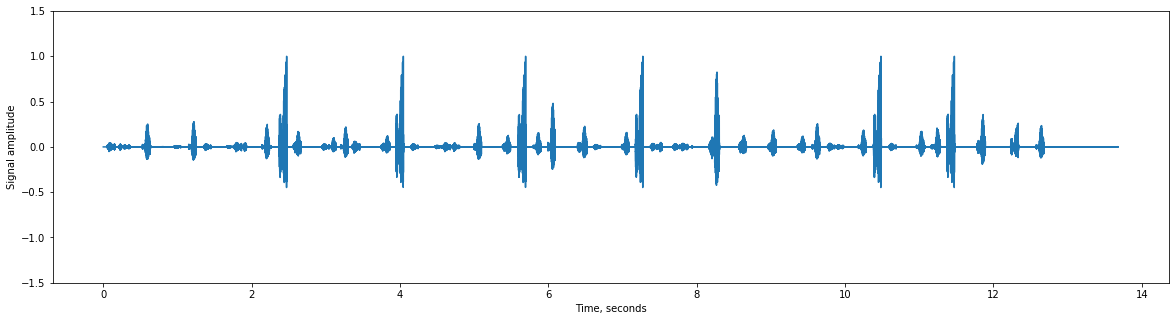

In [43]:
vxsu.plot_track(sound_track)

In [13]:
onsets = vxs.detect_onsets(sound_track, method='complex')

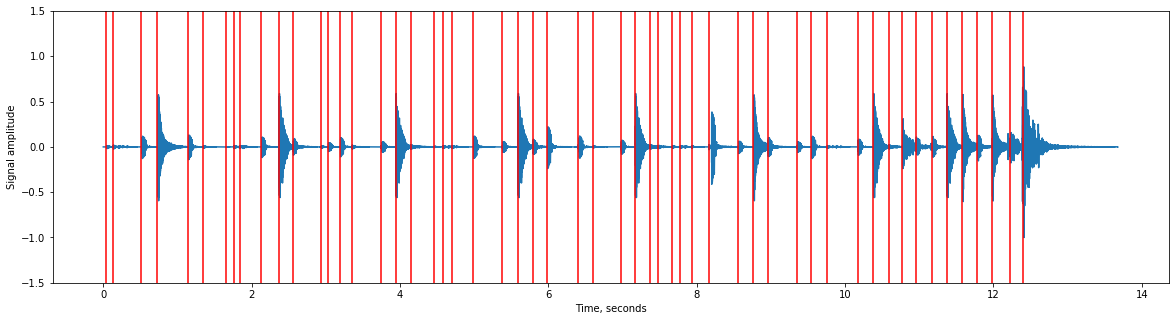

In [14]:
vxsu.plot_track(sound_track, onsets=onsets)

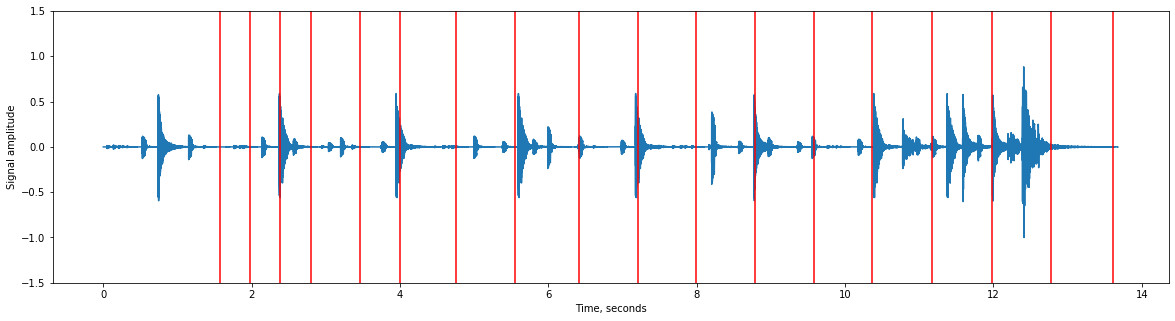

In [15]:
beats, tempo = vxs.detect_beats(sound_track, method='complex')
vxsu.plot_track(sound_track, onsets=beats)

In [16]:
sample_track_q = note_seq.quantize_note_sequence(sample_track, 4)
note_seq.plot_sequence(sample_track_q)

Loading BokehJS ...

In [17]:
sound_track_q = vxs.Track(note_seq.fluidsynth(sample_track_q, sample_rate=44100))

In [18]:
sample_track_q

ticks_per_quarter: 480
time_signatures {
  numerator: 4
  denominator: 4
}
key_signatures {
}
tempos {
  qpm: 75.0
}
notes {
  pitch: 42
  velocity: 51
  start_time: 0.05
  end_time: 0.135
  is_drum: true
  quantized_end_step: 1
}
notes {
  pitch: 42
  velocity: 59
  start_time: 0.135
  end_time: 0.15166666666666667
  is_drum: true
  quantized_start_step: 1
  quantized_end_step: 2
}
notes {
  pitch: 42
  velocity: 43
  start_time: 0.2016666666666667
  end_time: 0.2366666666666667
  is_drum: true
  quantized_start_step: 1
  quantized_end_step: 2
}
notes {
  pitch: 42
  velocity: 34
  start_time: 0.255
  end_time: 0.30333333333333334
  is_drum: true
  quantized_start_step: 1
  quantized_end_step: 2
}
notes {
  pitch: 42
  velocity: 33
  start_time: 0.315
  end_time: 0.3566666666666667
  is_drum: true
  quantized_start_step: 2
  quantized_end_step: 3
}
notes {
  pitch: 22
  velocity: 127
  start_time: 0.3616666666666667
  end_time: 0.4633333333333334
  is_drum: true
  quantized_start_step

In [19]:
vxsu.play_audio(sound_track_q)

In [20]:
print(tempo)

75.64109931938765


In [21]:
lr.beat.tempo(sound_track.wave, sr=sound_track.rate)

array([147.65625])

In [22]:
cp_specdesc = vxs.specdesc(sound_track, method='complex')

In [23]:
def plot_specdesc(sd, samplerate=44100, hop_length=512):
    times = lr.times_like(len(sd), sr=samplerate, hop_length=hop_length)
    fig = plt.figure(figsize=(20, 5))
    plt.plot(times, sd)

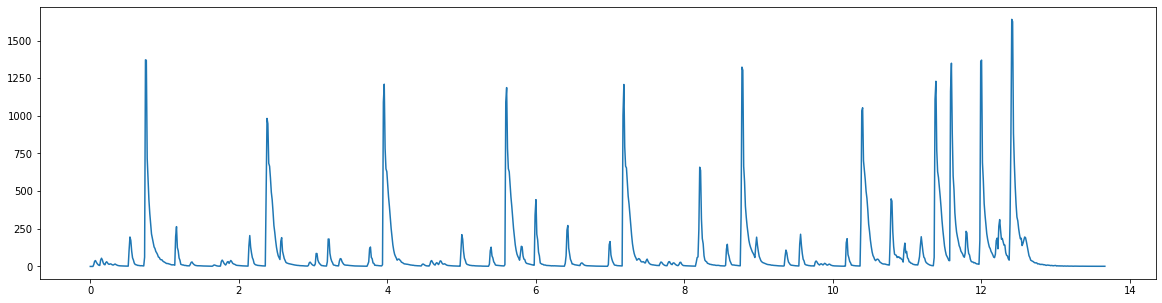

In [24]:
plot_specdesc(cp_specdesc)

In [25]:
lr.beat.tempo(onset_envelope=cp_specdesc, sr=44100, hop_length=512, aggregate=np.median)

array([105.46875])